# Notebook  Approche  supervisé

## Importation des modules

In [19]:
!pip install mlflow pyngrok --quiet
!pip install seaborn



Defaulting to user installation because normal site-packages is not writeable


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import multilabel_confusion_matrix
import time
from joblib import dump
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import jaccard_score
from contextlib import redirect_stdout
from io import StringIO
import sys


from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier

## Définition des fonctions

In [21]:

def evaluate_model(pipeline, X_test, y_test, mlb):
    """
    Evaluate the model using the provided pipeline and test data.

    Parameters:
        pipeline: Fitted scikit-learn pipeline containing the model.
        X_test: Test features.
        y_test: True labels for the test set.
        mlb: Fitted label encoder used for transforming labels.

    Returns:
        None
    """
    # Predictions on the test set
    y_pred = pipeline.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Print evaluation metrics
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)

    # Créer la matrice de confusion
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Afficher la matrice de confusion
    plt.figure(figsize=(10,8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=pipeline.classes_, yticklabels=pipeline.classes_)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [22]:
def tracker():
  # run tracking UI in the background
  get_ipython().system_raw("mlflow ui --port 5000 &")
  from pyngrok import ngrok

  # Terminate open tunnels if exist
  ngrok.kill()

  # Setting the authtoken (optional)
  NGROK_AUTH_TOKEN = "2e2sfIlj3qAvaM0F540Nv6j28RY_4zpiTmLho7K4dBjWbfRU"
  ngrok.set_auth_token(NGROK_AUTH_TOKEN)

  # Open an HTTPs tunnel on port 5000 for http://localhost:5000
  ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
  print("MLflow Tracking UI:", ngrok_tunnel.public_url)

## Importation des données et brève exploration

In [23]:
df= pd.read_csv('./my_data.csv')  
df.head()

,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount
0,minification failed returning unminified content,made first website using mvc work fine local m...,|asp.net|asp.net-mvc|bundling-and-minification|,24395412,40,49177,0.0,12
1,ajax request made flux app,creating react application flux architecture t...,|javascript|reactjs|reactjs-flux|,26632415,199,40698,0.0,6
2,gem install debugger error,running rail mac everything smoothly sudden ge...,|ruby-on-rails|ruby|rubygems|rvm|,24395453,25,28278,0.0,6
3,change body parser limit firebase,trying proxy file upload firebase cloud functi...,|node.js|express|firebase|google-cloud-functio...,45489810,7,946,NaN,1
4,io android material design hierarchical timing...,want animation introduced android material des...,|ios|uicollectionview|calayer|material-design|,26632893,11,895,0.0,3


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Title          49976 non-null  object 
 1   Body           50000 non-null  object 
 2   Tags           50000 non-null  object 
 3   Id             50000 non-null  int64  
 4   Score          50000 non-null  int64  
 5   ViewCount      50000 non-null  int64  
 6   FavoriteCount  42355 non-null  float64
 7   AnswerCount    50000 non-null  int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 3.1+ MB


In [25]:
df.isnull().sum()

Title              24
Body                0
Tags                0
Id                  0
Score               0
ViewCount           0
FavoriteCount    7645
AnswerCount         0
dtype: int64

In [26]:
df.fillna('', inplace=True)
data = df.copy()

C:\Users\ouedr\AppData\Local\Temp\ipykernel_21500\2364853322.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.fillna('', inplace=True)


### Aperçu des Tags les plus frequents

In [27]:
tags = []
for i in range(len(data)):
  tags.append(data["Tags"].iloc[i].split('|'))

In [28]:
nested_tags = []
for tag in tags:
  for subtag in tag:
    if subtag !="":
      nested_tags.append(subtag)

df_tags =  pd.DataFrame(nested_tags).rename(columns={0:"tags"})
df_tags = df_tags["tags"].value_counts().reset_index().sort_values("count", ascending=False)
df_tags.head(20)

,tags,count
0,python,4571
1,c#,4359
2,javascript,4044
3,java,4039
4,c++,2581
5,android,2532
6,.net,1986
7,html,1657
8,ios,1655
9,php,1652


## Encodage et séparation des données en trainset et testset

In [29]:
mlb = MultiLabelBinarizer()
mlb.fit(data['Tags'])
N = 20
top_n_tags = mlb.classes_[:N]
y = mlb.transform(data['Tags'])
y = np.argmax(y, axis=1)

In [30]:
X = data[['Title', 'Body']].apply(lambda x: ' '.join(x), axis=1)
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Expériences MLFLOW avec Logistic Classifier

In [14]:
from mlflow import mlflow

ModuleNotFoundError: No module named 'pkg_resources'

In [ ]:
mlflow.set_experiment("logistiC Classifier")

def track_experiment(X_train, y_train, X_test, y_test, param_grid, message, month):
    """
    Suivi des expériences avec différents hyperparamètres du logistiC Classifier à l'aide de MLflow.

    Paramètres:
        X_train : fonctionnalités de formation.
        y_train : étiquettes de formation.
        X_test : tester les fonctionnalités.
        y_test : tester les étiquettes.
        param_grid : Dictionnaire des hyperparamètres et de leurs plages.
        message : message à définir comme nom d'exécution dans MLflow.
        mois : mois pour lequel l'expérience est menée.

    Retour:
        Aucun
    """
    # Start MLflow run
    if mlflow.active_run():
        mlflow.end_run()
    else:
        mlflow.start_run(run_name="logistiC Classifier")

    # Log the month for which the experiment is conducted
    mlflow.log_param("month", month)

    # Loop over parameter grid
    for params in ParameterGrid(param_grid):
        # Start nested MLflow run
        with mlflow.start_run(nested=True):
            # Log hyperparameters
            for key, value in params.items():
                mlflow.log_param(key, value)

            # Instantiate model with current set of hyperparameters
            base_model = LogisticRegression(**params)
            model_logistic = OneVsRestClassifier(base_model)

            # Train the model
            start_time = time.time()
            model_logistic.fit(X_train, y_train)
            end_time = time.time()

            # Log model
            mlflow.sklearn.log_model(model_logistic, "model_logistic")
            # Register model in Model Registry
            model_uri = f"runs:/{mlflow.active_run().info.run_id}/model_logistic"
            registered_model = mlflow.register_model(model_uri, "Logistic Classifier model")

            # Make predictions
            y_pred = model_logistic.predict(X_test)

            # Calculate metrics
            jaccard = jaccard_score(y_test, y_pred, average='weighted')
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='weighted')
            recall = recall_score(y_test, y_pred, average='weighted')
            f1 = f1_score(y_test, y_pred, average='weighted')

            # Log metrics
            mlflow.log_metric("Jaccard", round(jaccard, 2))
            mlflow.log_metric("accuracy", round(accuracy, 2))
            mlflow.log_metric("precision", round(precision, 2))
            mlflow.log_metric("recall", round(recall, 2))
            mlflow.log_metric("f1", round(f1, 2))
            mlflow.log_metric("training_time", end_time - start_time)

# # Example usage:
param_grid_logistic = {
    "max_iter": [100],
    "solver" :['liblinear'],
}

months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

for month in months:
    track_experiment(X_train, y_train, X_test, y_test, param_grid=param_grid_logistic, message="logistiC Classifier", month=month)

NameError: name 'mlflow' is not defined

## Entrainement du modèle SGD Classifier

In [ ]:
mlflow.set_experiment("SGD Classifier")

def track_experiment(X_train, y_train, X_test, y_test, param_grid, message, month):
    """
    Suivi des expériences avec différents hyperparamètres du SGD Classifier à l'aide de MLflow
    Paramètres:
        X_train : fonctionnalités de formation.
        y_train : étiquettes de formation.
        X_test : tester les fonctionnalités.
        y_test : tester les étiquettes.
        param_grid : Dictionnaire des hyperparamètres et de leurs plages.
        message : message à définir comme nom d'exécution dans MLflow.
        mois : mois pour lequel l'expérience est menée.

    Retour:
        Aucun
    """
    # Start MLflow run
    if mlflow.active_run():
        mlflow.end_run()
    else:
        mlflow.start_run(run_name="SGD Classifier")

    # Log the month for which the experiment is conducted
    mlflow.log_param("month", month)

    # Loop over parameter grid
    for params in ParameterGrid(param_grid):
        # Start nested MLflow run
        with mlflow.start_run(nested=True):
            # Log hyperparameters
            for key, value in params.items():
                mlflow.log_param(key, value)

            # Instantiate model with current set of hyperparameters
            base_model = SGDClassifier(**params)
            model_sgd = OneVsRestClassifier(base_model)

            # Train the model
            start_time = time.time()
            model_sgd.fit(X_train, y_train)
            end_time = time.time()

            # Log model
            mlflow.sklearn.log_model(model_sgd, "model_sgd")
            # Register model in Model Registry
            model_uri = f"runs:/{mlflow.active_run().info.run_id}/model_sgd"
            registered_model = mlflow.register_model(model_uri, "SGD Classifier Model")

            # Make predictions
            y_pred = model_sgd.predict(X_test)

            # Calculate metrics
            jaccard = jaccard_score(y_test, y_pred, average='weighted')
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='weighted')
            recall = recall_score(y_test, y_pred, average='weighted')
            f1 = f1_score(y_test, y_pred, average='weighted')

            # Log metrics
            mlflow.log_metric("Jaccard", round(jaccard, 2))
            mlflow.log_metric("accuracy", round(accuracy, 2))
            mlflow.log_metric("precision", round(precision, 2))
            mlflow.log_metric("recall", round(recall, 2))
            mlflow.log_metric("f1", round(f1, 2))
            mlflow.log_metric("training_time", end_time - start_time)

# # Example usage:
param_grid = {
    "loss" : ["hinge", "modified_huber"],
    "max_iter": [1000]
}
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

for month in months:
    track_experiment(X_train, y_train, X_test, y_test, param_grid, message="SGD Classifier", month=month)

## Entrainement du modèle KNN Classifier

In [ ]:
mlflow.set_experiment("KNN Classifier")

def track_experiment(X_train, y_train, X_test, y_test, param_grid, message, month):
    """
    Suivi des expériences avec différents hyperparamètres du KNN Classifier à l'aide de MLflow.

    Paramètres:
        X_train : fonctionnalités de formation.
        y_train : étiquettes de formation.
        X_test : tester les fonctionnalités.
        y_test : tester les étiquettes.
        param_grid : Dictionnaire des hyperparamètres et de leurs plages.
        message : message à définir comme nom d'exécution dans MLflow.
        mois : mois pour lequel l'expérience est menée.

    Retour:
        Aucun
    """
    # Start MLflow run
    if mlflow.active_run():
        mlflow.end_run()
    else:
        mlflow.start_run(run_name="KNN Classifier")

    # Log the month for which the experiment is conducted
    mlflow.log_param("month", month)

    # Loop over parameter grid
    for params in ParameterGrid(param_grid):
        # Start nested MLflow run
        with mlflow.start_run(nested=True):
            # Log hyperparameters
            for key, value in params.items():
                mlflow.log_param(key, value)

            # Instantiate model with current set of hyperparameters
            model_knn = KNeighborsClassifier(**params)

            # Train the model
            start_time = time.time()
            model_knn.fit(X_train, y_train)
            end_time = time.time()

            # Log model
            mlflow.sklearn.log_model(model_knn, "model_knn")
            # Register model in Model Registry
            model_uri = f"runs:/{mlflow.active_run().info.run_id}/model_knn"
            registered_model = mlflow.register_model(model_uri, "KNN Model")

            # Make predictions
            y_pred = model_knn.predict(X_test)

            # Calculate metrics
            jaccard = jaccard_score(y_test, y_pred, average='weighted')
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='weighted')
            recall = recall_score(y_test, y_pred, average='weighted')
            f1 = f1_score(y_test, y_pred, average='weighted')

            # Log metrics
            mlflow.log_metric("Jaccard", round(jaccard, 2))
            mlflow.log_metric("accuracy", round(accuracy, 2))
            mlflow.log_metric("precision", round(precision, 2))
            mlflow.log_metric("recall", round(recall, 2))
            mlflow.log_metric("f1", round(f1, 2))
            mlflow.log_metric("training_time", end_time - start_time)

# Example usage:
param_grid_knn = {
    "n_neighbors": [7, 8, 9, 10]
}
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

for month in months:
    track_experiment(X_train, y_train, X_test, y_test, param_grid=param_grid_knn, message="KNN Classifier", month=month)


In [ ]:
tracker()

Après visualisation des différentes expériences sur ngrok, le meilleure modèle à retenir est logistic Classifier

## Visualisation des performances du meilleur modèle sur le trainset et le testset


In [31]:
best_model = LogisticRegression(solver = 'liblinear' , max_iter = 100)

In [32]:
pipeline = Pipeline([
      ('classifier', OneVsRestClassifier(best_model))
  ])
pipeline.fit(X, y)
y_pred = pipeline.predict(X)

C:\Users\ouedr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ouedr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ouedr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\ouedr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear 

C:\Users\ouedr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.91025
Precision: 0.9129443709095273
Recall: 0.91025
F1-score: 0.9097362065071615


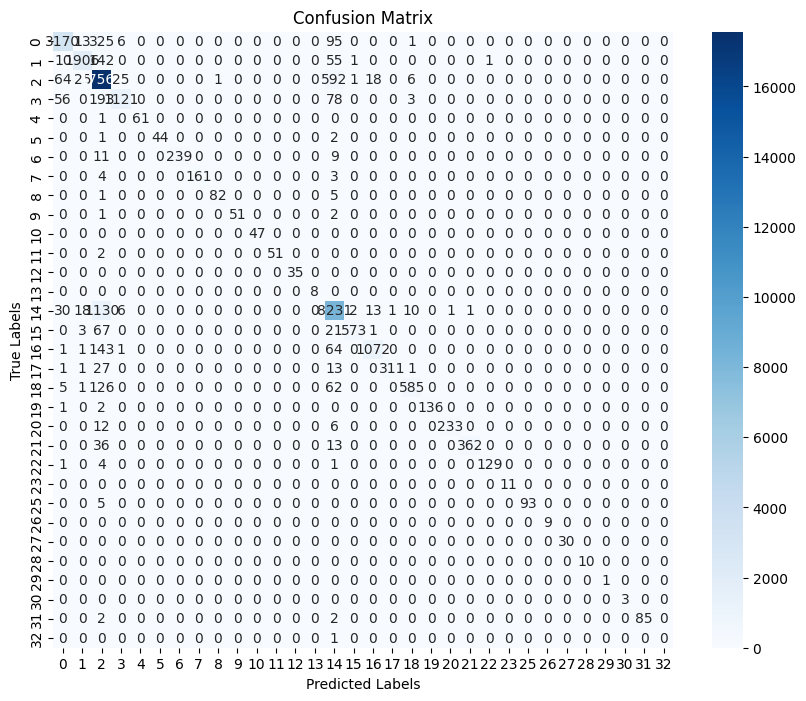

In [33]:
evaluate_model(pipeline, X_train, y_train, mlb)

C:\Users\ouedr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.9055
Precision: 0.9085032621812937
Recall: 0.9055
F1-score: 0.9049729518147153


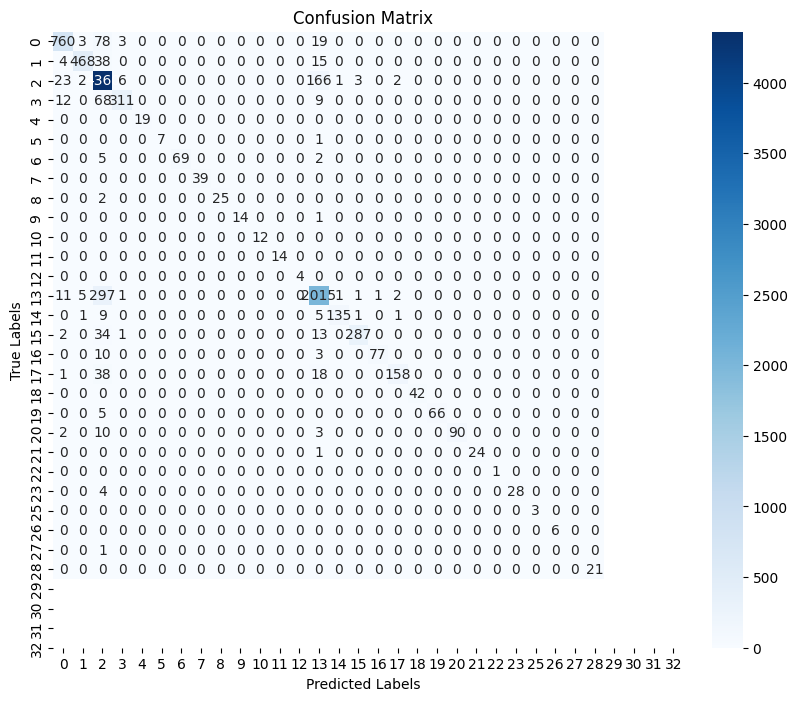

In [34]:
evaluate_model(pipeline, X_test, y_test, mlb)

## Enregistrement du meilleur modèle

In [36]:
dump(pipeline, 'model.classifier')

['model.classifier']